# Data Mining Midterm Project
### Why We Chose This Dataset:
This data set is extremely robust with information that is thought to be linked to health and nutrition. There are extensive subsets such as demographics, diet, exams, labs, and more that can be analyzed to find correlations that contribute positively or negatively to overall health. There are a lot of questions that can be answered with this data set; we will try to focus on a few we think are interesting to us
### Business Questions:
1. Can we identify habits/factors that positively or negatively affect health?
2. Is there a correlation between income level and overall health?
3. Can we identify the main diseases that affect certain demographics?
4. Does the presence of one disease increase the likelihood of the presence of another diease within an individual?
### Project Outline:
1. **Software Engineering** - Will build functions such as `dataLoader(), logger(), featurize(), cluster(),` and `dimRed()` to streamline data transformations within the dataframe(s).
2. **Data Engineering** - Will clean, organize, and transform the data for ease of use during the research and analysis portion of the project. Featurization. 
3. **Business Analysis** - Discover initial challenge questions for the dataset(s). Then evolve the questions as we iterate through the project. 
4. **Research** - After featurization, extract metadata on the full dataset and run clustering/dimentions reduction on various slices of the data. Metadata will be added to each cluster. Each iteration may vary on addition/deletion of features as we attempts to gain a conclusion on our business questions. 
### Resources:
- https://www.kaggle.com/code/gopalkholade/diabetes-prediction

In [204]:
import pandas as pd
import numpy as np
import re
import sklearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import plotly.express as px
from scipy.sparse.linalg import svds
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [205]:
demo = pd.read_csv('nhnes/demographic.csv')
diet = pd.read_csv('nhnes/diet.csv')
exam = pd.read_csv('nhnes/examination.csv')
labs = pd.read_csv('nhnes/labs.csv')
ques = pd.read_csv('nhnes/questionnaire.csv')
meds = pd.read_csv('nhnes/medications.csv', encoding='latin1')

In [266]:
def null_handler(df):
    orig_col = df.shape[1]
    orig_row = df.shape[0]

    col_perc = 50.0
    row_perc = 75.0

    min_col =  int(((100-col_perc)/100)*df.shape[0] + 1)
    df = df.dropna( axis=1, thresh=min_col)
    print("Dropped {} columns with over 50% null values.".format(orig_col - df.shape[1]))

    min_row =  int(((100-row_perc)/100)*df.shape[1] + 1)
    df = df.dropna( axis=0, thresh=min_row)
    print("Dropped {} rows with over 75% null values.".format(orig_row - df.shape[0]))
    
    for i in df.columns:
        df[i] = df[i].fillna(df[i].mode()[0])
    print("Replaced remaining null values with mode of column.")
    return df
    
def get_nulls(df):
    sum_null = df.isnull().sum()
    df_shape = df.shape[0]
    null = 100 * (sum_null / df_shape)
    return pd.DataFrame({'nullPercent': null})

def corr_matrix(df, title):
    cmap = sns.color_palette("magma", as_cmap=True)
    fig = plt.figure(figsize=(10, 8))
    map = sns.heatmap(df.corr(), cmap=cmap)
    plt.title(title,fontsize=15)
    labels=df.columns
    plt.show()

In [249]:
df = pd.concat([labs, exam, demo, diet, ques], axis=1)
df = df.loc[:,~df.columns.duplicated()]
df

,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,LBDAPBSI,LBXSAL,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557.0,4.3,4.3,39.0,3447.6,11.03,NaN,NaN,NaN,4.1,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558.0,153.0,153.0,50.0,4420.0,306.00,NaN,NaN,NaN,4.7,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559.0,11.9,11.9,113.0,9989.2,10.53,142196.890197,57.0,0.57,3.7,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560.0,16.0,16.0,76.0,6718.4,21.05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561.0,255.0,255.0,147.0,12994.8,173.47,142266.006548,92.0,0.92,4.3,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150.0,26.0,NaN,NaN,NaN
10171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,155.0,135.0,NaN,195.0,42.0,NaN,NaN,NaN
10173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
df = null_handler(df)
df

Dropped 1259 columns with over 50% null values.
Dropped 144 rows with over 75% null values.
Replaced remaining null values with mode of column.


,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,LBXSASSI,...,SMDANY,SMAQUEX.y,WHD010,WHD020,WHQ030,WHQ040,WHD050,WHQ070,WHD140,WHQ150
0,73557.0,4.3,4.3,39.0,3447.6,11.03,4.1,41.0,129.0,16.0,...,1.0,2.0,69.0,180.0,3.0,3.0,210.0,2.0,270.0,62.0
1,73558.0,153.0,153.0,50.0,4420.0,306.00,4.7,47.0,97.0,18.0,...,1.0,2.0,71.0,200.0,3.0,3.0,160.0,2.0,250.0,25.0
2,73559.0,11.9,11.9,113.0,9989.2,10.53,3.7,37.0,99.0,22.0,...,2.0,2.0,70.0,195.0,3.0,2.0,195.0,2.0,228.0,35.0
3,73560.0,16.0,16.0,76.0,6718.4,21.05,4.4,44.0,59.0,20.0,...,2.0,2.0,66.0,160.0,1.0,2.0,180.0,2.0,180.0,40.0
4,73561.0,255.0,255.0,147.0,12994.8,173.47,4.3,43.0,78.0,36.0,...,2.0,2.0,67.0,120.0,2.0,1.0,150.0,2.0,170.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10166,73557.0,4.2,4.2,95.0,8398.0,5.00,4.4,44.0,59.0,20.0,...,2.0,2.0,69.0,220.0,1.0,2.0,245.0,2.0,245.0,61.0
10167,73557.0,4.2,4.2,95.0,8398.0,5.00,4.4,44.0,59.0,20.0,...,2.0,2.0,70.0,173.0,3.0,3.0,173.0,2.0,190.0,55.0
10169,73557.0,4.2,4.2,95.0,8398.0,5.00,4.4,44.0,59.0,20.0,...,2.0,2.0,66.0,180.0,3.0,3.0,170.0,2.0,180.0,40.0
10170,73557.0,4.2,4.2,95.0,8398.0,5.00,4.4,44.0,59.0,20.0,...,2.0,2.0,69.0,150.0,3.0,3.0,150.0,2.0,150.0,26.0


In [256]:
col_decoder = {
'ALQ101' : 'drink_alcohol',
'ALQ130' : 'alcohol_per_day',
'AUQ136' : 'ear_infections',
'BMDAVSAD' : 'saggital_abdominal_avg',
'BMXARMC' : 'arm_circum',
'BMXBMI' : 'BMI',
'BMXLEG' : 'leg_length',
'BMXSAD1' : 'saggital_abdominal_1',
'BMXSAD2' : 'saggital_abdominal_2',
'BMXWAIST' : 'waist_circum',
'BMXWT' : 'weight_kg',
'BPQ020' : 'high_bp',
'BPQ056' : 'measure_bp_home',
'BPQ059' : 'measure_bp_doctor',
'BPQ060' : 'cholesterol_checked',
'BPQ070' : 'cholesterol_checked_1y',
'BPQ080' : 'high_cholesterol',
'BPQ090D' : 'cholesterol_prescription',
'BPXDI1' : 'diastolic_bp',
'BPXML1' : 'cuff_max_inflation',
'BPXSY1' : 'blood_pressure_1',
'BPXSY2' : 'blood_pressure_2',
'BPXSY3' : 'blood_pressure_3',
'CBD070' : 'grocery_budget',
'CBD090' : 'nonfood_budget',
'CBD110' : 'food_budget',
'CBD120' : 'restaurant_budget',
'CBD130' : 'food_delivery_budget',
'CBQ505' : 'fast_food',
'CBQ535' : 'saw_nutrition_fast_food',
'CBQ545' : 'use_nutrition_fast_food',
'CBQ550' : 'eat_restaurants',
'CBQ552' : 'eat_chain_restaurants',
'CBQ580' : 'saw_nutrition_restaurant',
'CBQ590' : 'use_nutrition_restaurant',
'CBQ596' : 'saw_my_plate',
'CDQ001' : 'chest_pain_ever',
'CDQ010' : 'short_breath_stairs',
'CSQ030' : 'sensative_smell',
'CSQ100' : 'loss_of_taste',
'CSQ110' : 'taste_in_mouth',
'CSQ202' : 'dry_mouth',
'CSQ204' : 'nasal_congestion',
'CSQ210' : 'wisdom_teeth_removed',
'CSQ220' : 'tonsils_removed',
'CSQ240' : 'head_injury',
'CSQ250' : 'broken_nose',
'CSQ260' : 'sinus_infections',
'DBD100' : 'salt_frequency',
'DBD895' : 'meals_not_homemade',
'DBD900' : 'meals_fast_food',
'DBD905' : 'meals_prepackaged',
'DBD910' : 'frozen_meals_per_month',
'DBQ095Z' : 'salt_type',
'DBQ197' : 'milk_product_per_month',
'DBQ229' : 'milk_drinker',
'DBQ700' : 'healthy_diet',
'DEQ034C' : 'long_sleeve_shirt',
'DEQ034D' : 'use_sunscreen',
'DEQ038G' : 'sunburn_1y',
'DIQ010' : 'diabetes',
'DIQ050' : 'taking_insulin',
'DIQ160' : 'prediabetes',
'DIQ170' : 'diabetes_risk',
'DIQ172' : 'diabetes_concern',
'DIQ180' : 'blood_test_3y',
'DLQ010' : 'deaf',
'DLQ020' : 'blind',
'DLQ040' : 'mental_issues',
'DLQ050' : 'difficulty_walking',
'DLQ060' : 'difficulty_dressing',
'DLQ080' : 'difficulty_errands',
'DMDBORN4' : 'born_in_us2',
'DMDHHSIZ' : 'people_in_house',
'DMDHHSZB' : 'children_in_house',
'DMDHHSZE' : 'people_over_60_in_house',
'DMDMARTL' : 'Marital_Status',
'DPQ010' : 'no_interest_2w',
'DPQ020' : 'depression',
'DPQ030' : 'trouble_sleeping_2w',
'DPQ040' : 'fatigue_2w',
'DPQ050' : 'eating_problems_2w',
'DPQ060' : 'feel_bad_2w',
'DPQ070' : 'trouble_concentrating_2w',
'DPQ080' : 'speaking_problems_2w',
'DPQ090' : 'suicidal_2w',
'DPQ100' : 'depression_difficulty',
'DR1.320Z' : 'water',
'DR1_320Z' : 'plain_water_yesterday',
'DR1_330Z' : 'tap_water_yesterday',
'DR1BWATZ' : 'bottled_water_yesterday',
'DR1HELPD' : 'interview_help',
'DR1TACAR' : 'dietary_alpha_carotene',
'DR1TALCO' : 'alcohol',
'DR1TATOC' : 'dietary_vitamin_e',
'DR1TBCAR' : 'dietary_beta_carotene',
'DR1TCAFF' : 'caffeine',
'DR1TCALC' : 'dietary_calcium',
'DR1TCARB' : 'carb',
'DR1TCHL' : 'dietary_choline',
'DR1TCHOL' : 'cholesterol',
'DR1TCOPP' : 'dietary_copper',
'DR1TCRYP' : 'dietary_beta_cryptoxanthin',
'DR1TFA' : 'dietary_folic_acid',
'DR1TFF' : 'folate_food',
'DR1TFIBE' : 'fiber',
'DR1TFOLA' : 'dietary_folate',
'DR1TIRON' : 'dietary_iron',
'DR1TKCAL' : 'calories',
'DR1TLYCO' : 'dietary_lycopene',
'DR1TLZ' : 'dietary_lutein',
'DR1TM181' : 'octadecenoic_percent',
'DR1TMAGN' : 'magnesium',
'DR1TMFAT' : 'monounsaturated_fats',
'DR1TMOIS' : 'moisture',
'DR1TNIAC' : 'dietary_niacin',
'DR1TP183' : 'octadecatrienoic_percent',
'DR1TPHOS' : 'dietary_phosphorus',
'DR1TPOTA' : 'dietary_potassium',
'DR1TPROT' : 'protein',
'DR1TRET' : 'dietary_retinol',
'DR1TS140' : 'tetradeconoic_percent',
'DR1TSELE' : 'dietary_selenium',
'DR1TSODI' : 'sodium',
'DR1TSUGR' : 'sugar',
'DR1TTFAT' : 'fat',
'DR1TTHEO' : 'dietary_theobromine',
'DR1TVARA' : 'dietary_vitamin_a',
'DR1TVB1' : 'dietary_b1',
'DR1TVB12' : 'dietary_b12',
'DR1TVB2' : 'dietary_b2',
'DR1TVB6' : 'dietary_b6',
'DR1TVC' : 'dietary_vit_c',
'DR1TVD' : 'dietary_vit_d',
'DR1TVK' : 'dietary_vit_k',
'DR1TZINC' : 'dietary_zinc',
'DRABF' : 'breast_fed',
'DRQSPREP' : 'salt_used',
'DUQ200' : 'marijuana',
'DUQ370' : 'needle_drugs',
'FSD032A' : 'food_insecure',
'FSD032B' : 'not_enough_food',
'FSD032C' : 'cheap_food',
'FSD032D' : 'cheap_food_children',
'FSD032E' : 'bad_food_children',
'FSD032F' : 'low_food_children',
'FSD151' : 'emergency_food_received',
'FSDAD' : 'food_secure',
'FSDCH' : 'child_food_secure',
'FSDHH' : 'household_food_secure',
'FSQ162' : 'wic_received',
'FSQ165' : 'food_stamps',
'HEQ010' : 'hepetitis_b',
'HEQ030' : 'hepetitis_c',
'HIQ011' : 'health_insurance',
'HIQ210' : 'insurance_gap',
'HIQ270' : 'prescription_insurance',
'HOD050' : 'rooms_in_home',
'HOQ065' : 'homeowner',
'HSAQUEX' : 'health_status_source_data',
'HSD010' : 'general_health',
'HSQ500' : 'ever_had_cold',
'HSQ510' : 'intestinal_illness',
'HSQ520' : 'ever_had_flu',
'HSQ571' : 'donate_blood',
'HSQ590' : 'hiv',
'HUQ010' : 'general_health2',
'HUQ020' : 'health_compared_last_year',
'HUQ030' : 'routine_healthcare',
'HUQ041' : 'healthcare_location',
'HUQ051' : 'dr_visits',
'HUQ071' : 'overnight_hospital',
'HUQ090' : 'mental_health_treatment',
'IMQ011' : 'hepatitis_a_vaccine',
'IMQ020' : 'hepatitis_b_vaccine',
'IND235' : 'monthly_income',
'INDFMMPC' : 'poverty_level_category',
'INDFMMPI' : 'poverty_level_index',
'INDFMPIR' : 'family_income',
'INQ012' : 'self_employ_income',
'INQ020' : 'income_from_wages',
'INQ030' : 'income_from_SS',
'INQ060' : 'disability_income',
'INQ080' : 'retirement_income',
'INQ090' : 'ss_income',
'INQ132' : 'state_assistance_income',
'INQ140' : 'investment_income',
'INQ150' : 'other_income',
'INQ244' : 'family_savings',
'LBDBCDLC' : 'blood_cadmium',
'LBDBGMLC' : 'methyl_mercury',
'LBDHDD' : 'HDL_mg',
'LBDIHGLC' : 'inorganic_mercury',
'LBDNENO' : 'neutrophils_percent',
'LBDTHGLC' : 'blood_mercury',
'LBDWFL' : 'floride_water',
'LBXEOPCT' : 'eosinophils_percent',
'LBXGH' : 'glyco_hemoglobin',
'LBXLYPCT' : 'lymphocite_percent',
'LBXMC' : 'hemoglobin_concentration',
'LBXSAL' : 'blood_albumin',
'LBXSCA' : 'blood_calcium',
'LBXSGL' : 'serum_glucose_mg',
'LBXSTP' : 'blood_protein',
'MCQ010' : 'asthma_ever',
'MCQ025' : 'asthma_age',
'MCQ035' : 'asthma',
'MCQ040' : 'asthma_year',
'MCQ050' : 'asthma_ER',
'MCQ053' : 'anemia',
'MCQ070' : 'psoriasis',
'MCQ080' : 'overweight',
'MCQ082' : 'celiac_disease',
'MCQ086' : 'gluten_free',
'MCQ092' : 'blood_transfusion',
'MCQ149' : 'menstruate',
'MCQ151' : 'menstruate_age',
'MCQ160A' : 'arthritis',
'MCQ160B' : 'congestive_heart_failure',
'MCQ160C' : 'coronary_heart_disease',
'MCQ160D' : 'angina',
'MCQ160E' : 'heart_attack',
'MCQ160F' : 'stroke',
'MCQ160G' : 'emphysema',
'MCQ160K' : 'bronchitis_ever',
'MCQ160L' : 'liver_condition_ever',
'MCQ160M' : 'thyroid_ever',
'MCQ160N' : 'gout',
'MCQ160O' : 'COPD',
'MCQ170K' : 'bronchitis_now',
'MCQ170L' : 'liver_condition',
'MCQ170M' : 'thyroid_now',
'MCQ180A' : 'arthritis_age',
'MCQ180B' : 'heart_failure_age',
'MCQ180C' : 'heart_disease_age',
'MCQ180D' : 'angina_age',
'MCQ180E' : 'heart_attack_age',
'MCQ180F' : 'stroke_age',
'MCQ180G' : 'emphysema_age',
'MCQ180K' : 'bronchitis_age',
'MCQ180L' : 'liver_condition_age',
'MCQ180M' : 'thyroid_age',
'MCQ180N' : 'gout_age',
'MCQ195' : 'arthritis_type',
'MCQ203' : 'jaundice',
'MCQ206' : 'jaundice_age',
'MCQ220' : 'cancer',
'MCQ230A' : 'cancer_type1',
'MCQ230B' : 'cancer_type2',
'MCQ230C' : 'cancer_type3',
'MCQ230D' : 'cancer_type4',
'MCQ240A' : 'bladder_cancer_age',
'MCQ240AA' : 'test_cancer_age',
'MCQ240B' : 'blood_cancer_age',
'MCQ240BB' : 'thyroid_cancer_age',
'MCQ240C' : 'bone_cancer_age',
'MCQ240CC' : 'uterine_cancer_age',
'MCQ240D' : 'brain_cancer_age',
'MCQ240DK' : 'cancer_age',
'MCQ240E' : 'breast_cancer_age',
'MCQ240F' : 'cervical_cancer_age',
'MCQ240G' : 'colon_cancer_age',
'MCQ240H' : 'esoph_cancer_age',
'MCQ240I' : 'gallbladder_cancer_age',
'MCQ240J' : 'kidney_cancer_age',
'MCQ240K' : 'larynx_cancer_age',
'MCQ240L' : 'leukemia_age',
'MCQ240M' : 'liver_cancer_age',
'MCQ240N' : 'lung_cancer_age',
'MCQ240O' : 'lymphoma_age',
'MCQ240P' : 'melanoma_age',
'MCQ240Q' : 'mouth_cancer_age',
'MCQ240R' : 'nervous_cancer_age',
'MCQ240S' : 'ovarian_cancer_age',
'MCQ240T' : 'pancreatic_cancer_age',
'MCQ240U' : 'prostate_cancer_age',
'MCQ240V' : 'rectal_cancer_age',
'MCQ240X' : 'skin_cancer_age',
'MCQ240Y' : 'soft_cancer_age',
'MCQ240Z' : 'stomach_cancer_age',
'MCQ300A' : 'relative_heart_attack',
'MCQ300B' : 'relative_asthma',
'MCQ300C' : 'relative_diabetes',
'MCQ365A' : 'need_weight_loss',
'MCQ365B' : 'need_exercise',
'MCQ365C' : 'need_reduce_salt',
'MCQ365D' : 'need_reduce_calories',
'MCQ370A' : 'losing_weight',
'MCQ370B' : 'excercising',
'MCQ370C' : 'reducing_salt',
'MCQ370D' : 'reducing_fat',
'MGDCGSZ' : 'grip_strength',
'OCD150' : 'work_done',
'OCD270' : 'months_of_work',
'OCD390G' : 'type_of_work',
'OCD395' : 'job_duration',
'OCQ260' : 'non_govt_employee',
'OHQ030' : 'visit_dentist',
'OHQ033' : 'dentist_reason',
'OHQ620' : 'aching_mouth',
'OHQ640' : 'mouth_problems',
'OHQ680' : 'mouth_problems2',
'OHQ770' : 'need_dental',
'OHQ835' : 'gum_disease',
'OHQ845' : 'teeth_health',
'OHQ850' : 'gum_treatment',
'OHQ855' : 'loose_teeth',
'OHQ860' : 'teeth_bone_loss',
'OHQ865' : 'weird_tooth',
'OHQ870' : 'floss',
'OHQ875' : 'use_mouthwash',
'OHQ880' : 'oral_cancer_exam',
'OHQ885' : 'oral_cancer_exam2',
'OSQ060' : 'osteoporosis',
'OSQ130' : 'take_prednisone',
'OSQ230' : 'metal_objects',
'PAAQUEX' : 'question_source',
'PAD680' : 'sedentary_time',
'PAQ605' : 'vigorous_work',
'PAQ620' : 'moderate_work',
'PAQ635' : 'walk_or_bike',
'PAQ650' : 'vigorous_recreation',
'PAQ665' : 'moderate_recreation',
'PAQ710' : 'tv_hours',
'PAQ715' : 'pc_hours',
'PEASCST1' : 'bp_status',
'PEASCTM1' : 'blood_pressure_time',
'PFQ049' : 'work_limitations',
'PFQ051' : 'work_limitations2',
'PFQ054' : 'walk_equipment_required',
'PFQ057' : 'confusion_memory_problems',
'PFQ090' : 'special_healthcare_equipment',
'PUQ100' : 'insecticide_used',
'PUQ110' : 'weedkiller_used',
'RIAGENDR' : 'gender',
'RIDAGEYR' : 'age',
'RIDRETH1' : 'hispanic',
'RXQ510' : 'take_aspirin',
'SLD010H' : 'sleep_hours',
'SLQ050' : 'trouble_sleeping',
'SLQ060' : 'sleep_disorder',
'SMAQUEX.x' : 'question_mode',
'SMAQUEX.y' : 'question_mode2',
'SMAQUEX2' : 'question_mode3',
'SMD460' : 'smokers_in_house',
'SMDANY' : 'tobaco_1w',
'SMQ681' : 'smoked_1w',
'SMQ851' : 'tobaco2_1w',
'SMQ856' : 'smoked_at_work',
'SMQ858' : 'someone_smoked_at_job',
'SMQ860' : 'smoked_at_restaurant',
'SMQ863' : 'nicotine_1w',
'SMQ866' : 'smoked_at_bar',
'SMQ870' : 'smoked_in_car',
'SMQ872' : 'someone_smoked_in_car',
'SMQ874' : 'smoked_another_home',
'SMQ876' : 'someone_smoked_in_home',
'SMQ878' : 'smoked_other_building',
'SMQ880' : 'someone_smoked_other_building',
'SXD021' : 'sex_ever',
'URXUCR' : 'creatinine_urine',
'WHD010' : 'height_in',
'WHD020' : 'current_weight_lb',
'WHD050' : 'weight_1y',
'WHD110' : 'weight_10y',
'WHD120' : 'weight_age_25',
'WHD140' : 'greatest_weight',
'WHQ030' : 'overweight_self',
'WHQ040' : 'weightloss_desire',
'WHQ070' : 'weightloss_attempt',
'WHQ150' : 'age_when_heaviest'
}

keep_cols = list(col_decoder.values())
df = df.rename(columns = col_decoder)
df = df[df.columns.intersection(keep_cols)]
df.head()

,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,glyco_hemoglobin,...,tobaco_1w,question_mode2,height_in,current_weight_lb,overweight_self,weightloss_desire,weight_1y,weightloss_attempt,greatest_weight,age_when_heaviest
0,4.1,9.5,554.0,6.5,42.2,3.4,2.0,33.4,65.0,13.9,...,1.0,2.0,69.0,180.0,3.0,3.0,210.0,2.0,270.0,62.0
1,4.7,9.2,219.0,7.8,27.3,6.1,7.4,32.5,50.0,9.1,...,1.0,2.0,71.0,200.0,3.0,3.0,160.0,2.0,250.0,25.0
2,3.7,8.9,183.0,5.9,13.9,5.6,4.9,34.3,60.0,8.9,...,2.0,2.0,70.0,195.0,3.0,2.0,195.0,2.0,228.0,35.0
3,4.4,9.4,92.0,7.1,29.6,1.7,4.6,34.0,61.0,5.4,...,2.0,2.0,66.0,160.0,1.0,2.0,180.0,2.0,180.0,40.0
4,4.3,10.0,104.0,7.1,20.5,2.4,4.5,33.0,85.0,4.9,...,2.0,2.0,67.0,120.0,2.0,1.0,150.0,2.0,170.0,60.0


In [293]:
diabetes_df = df.groupby('diabetes').mean().sort_values(by=['diabetes'], ascending=True)
diabetes_df

,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,glyco_hemoglobin,...,tobaco_1w,question_mode2,height_in,current_weight_lb,overweight_self,weightloss_desire,weight_1y,weightloss_attempt,greatest_weight,age_when_heaviest
diabetes,,,,,,,,,,,,,,,,,,,,,
1.0,4.321845,9.474084,98.523745,7.109769,33.146811,2.833786,4.033107,33.826866,51.519674,5.576934,...,1.824966,1.991859,241.369064,272.150611,1.605156,2.165536,357.985075,1.710991,396.088195,592.899593
2.0,4.323462,9.455305,98.797342,7.105051,32.919783,2.789697,4.052142,33.807623,51.884446,5.560808,...,1.862698,1.887302,120.531964,215.716718,1.620936,2.152680,256.848858,1.807887,251.674868,346.363796
3.0,4.302174,9.423913,95.690217,7.095652,32.669022,2.878804,4.023370,33.783152,53.141304,5.491304,...,1.836957,1.972826,66.021739,193.038043,1.500000,2.086957,236.847826,1.619565,265.711957,49.994565
7.0,4.100000,9.000000,155.000000,6.700000,23.000000,1.700000,6.300000,33.600000,57.000000,5.500000,...,2.000000,2.000000,66.000000,160.000000,1.000000,2.000000,180.000000,2.000000,180.000000,40.000000
9.0,4.400000,9.460000,92.600000,7.080000,38.400000,1.080000,3.880000,33.520000,49.800000,5.400000,...,1.800000,1.600000,64.400000,2125.800000,1.800000,3.600000,2138.600000,1.400000,210.800000,44.400000


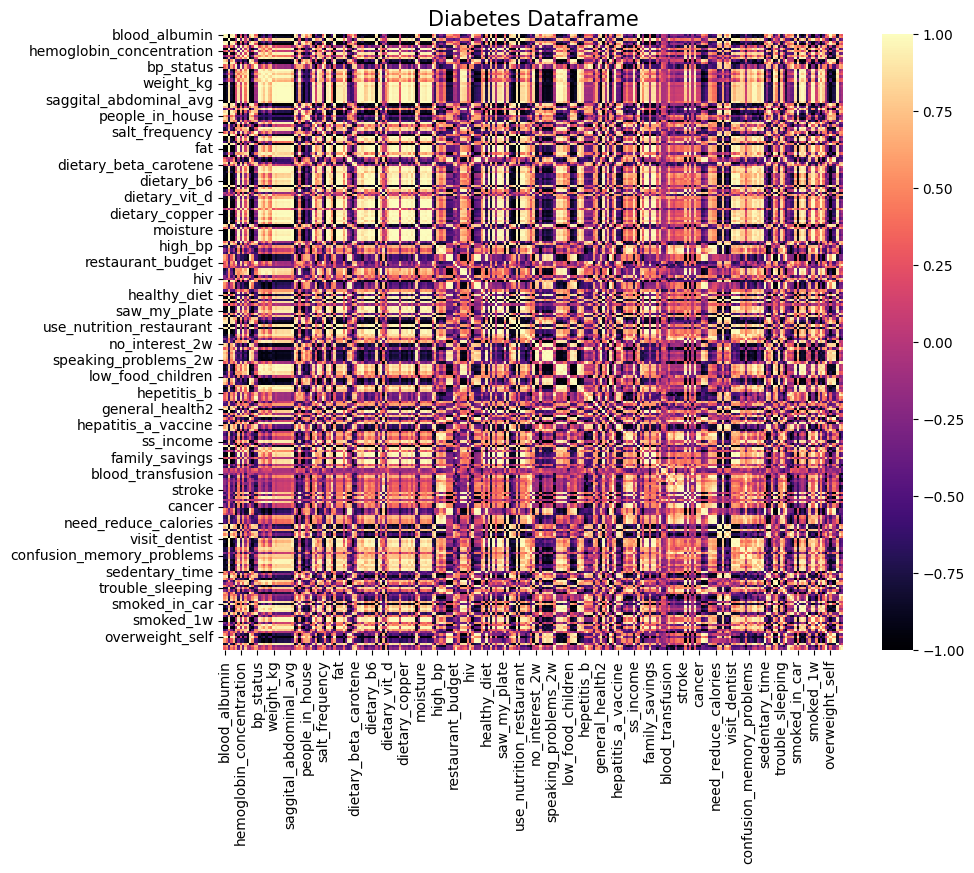

In [267]:
corr_matrix(diabetes_df, 'Diabetes Dataframe')

In [294]:
glyco_df = df.groupby('glyco_hemoglobin').mean().sort_values(by=['glyco_hemoglobin'], ascending=True)
glyco_df.head()

,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,inorganic_mercury,...,tobaco_1w,question_mode2,height_in,current_weight_lb,overweight_self,weightloss_desire,weight_1y,weightloss_attempt,greatest_weight,age_when_heaviest
glyco_hemoglobin,,,,,,,,,,,,,,,,,,,,,
3.5,3.1,9.200000,77.000000,6.100000,37.800000,0.600000,3.100000,32.300000,59.000000,1.0,...,2.000000,2.0,64.0,205.000000,1.000000,2.0,190.0,1.0,215.0,53.000000
3.7,3.7,8.900000,79.000000,6.900000,28.800000,2.000000,4.200000,34.600000,40.000000,1.0,...,2.000000,2.0,66.0,160.000000,1.000000,2.0,180.0,2.0,180.0,40.000000
3.8,4.4,9.100000,81.000000,6.800000,45.800000,1.200000,1.700000,34.000000,63.000000,1.0,...,2.000000,2.0,64.0,170.000000,3.000000,2.0,170.0,2.0,170.0,49.000000
3.9,4.9,9.700000,88.000000,7.900000,30.400000,1.500000,3.700000,33.600000,48.000000,1.0,...,2.000000,2.0,66.0,160.000000,1.000000,2.0,180.0,2.0,180.0,40.000000
4.1,4.1,9.166667,88.333333,7.066667,28.633333,5.966667,3.533333,33.366667,38.666667,1.0,...,1.666667,2.0,67.0,167.666667,1.666667,2.0,182.0,2.0,182.0,47.666667


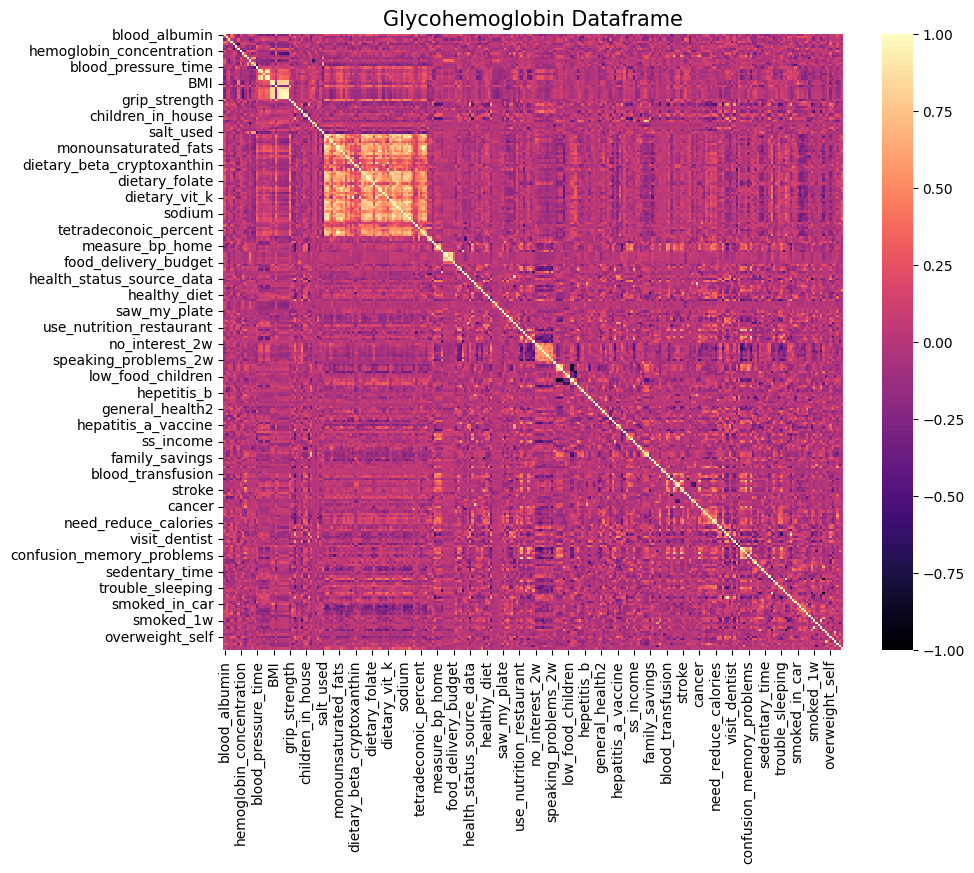

In [295]:
corr_matrix(glyco_df, 'Glycohemoglobin Dataframe')

In [297]:
bmi_df = df.groupby('BMI').mean().sort_values(by=['BMI'], ascending=True)
bmi_df

,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,glyco_hemoglobin,...,tobaco_1w,question_mode2,height_in,current_weight_lb,overweight_self,weightloss_desire,weight_1y,weightloss_attempt,greatest_weight,age_when_heaviest
BMI,,,,,,,,,,,,,,,,,,,,,
12.1,4.4,9.4,92.0,7.1,28.800000,1.700000,3.800000,33.800000,48.000000,5.4,...,2.000000,1.0,67.000000,135.000000,3.000000,2.000000,120.000000,1.000000,180.000000,40.000000
12.3,4.4,9.4,92.0,7.1,39.400000,1.700000,4.700000,34.000000,54.000000,5.4,...,2.000000,1.0,69.000000,190.000000,3.000000,2.000000,175.000000,1.000000,180.000000,40.000000
12.6,4.4,9.4,92.0,7.1,40.466667,2.500000,3.900000,33.866667,61.000000,5.4,...,2.000000,2.0,67.666667,181.000000,1.666667,2.333333,170.000000,1.333333,187.666667,40.333333
12.7,4.4,9.4,92.0,7.1,47.600000,2.000000,2.800000,34.400000,48.000000,5.4,...,2.000000,2.0,66.000000,160.000000,1.000000,2.000000,180.000000,2.000000,180.000000,40.000000
12.9,4.4,9.4,92.0,7.1,38.100000,3.014286,3.685714,34.100000,46.428571,5.4,...,1.857143,2.0,66.714286,169.857143,1.571429,2.000000,179.571429,2.000000,185.428571,50.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70.1,4.2,9.4,86.0,7.4,25.400000,2.300000,5.500000,33.200000,45.000000,5.3,...,2.000000,2.0,69.000000,170.000000,3.000000,3.000000,170.000000,2.000000,220.000000,62.000000
71.5,3.5,9.3,103.0,8.3,19.500000,3.400000,6.800000,31.300000,59.000000,6.8,...,2.000000,2.0,66.000000,160.000000,1.000000,2.000000,180.000000,2.000000,180.000000,40.000000
74.1,4.0,9.3,94.0,7.6,17.000000,0.600000,9.000000,35.000000,57.000000,5.7,...,2.000000,2.0,66.000000,160.000000,1.000000,2.000000,180.000000,2.000000,180.000000,40.000000


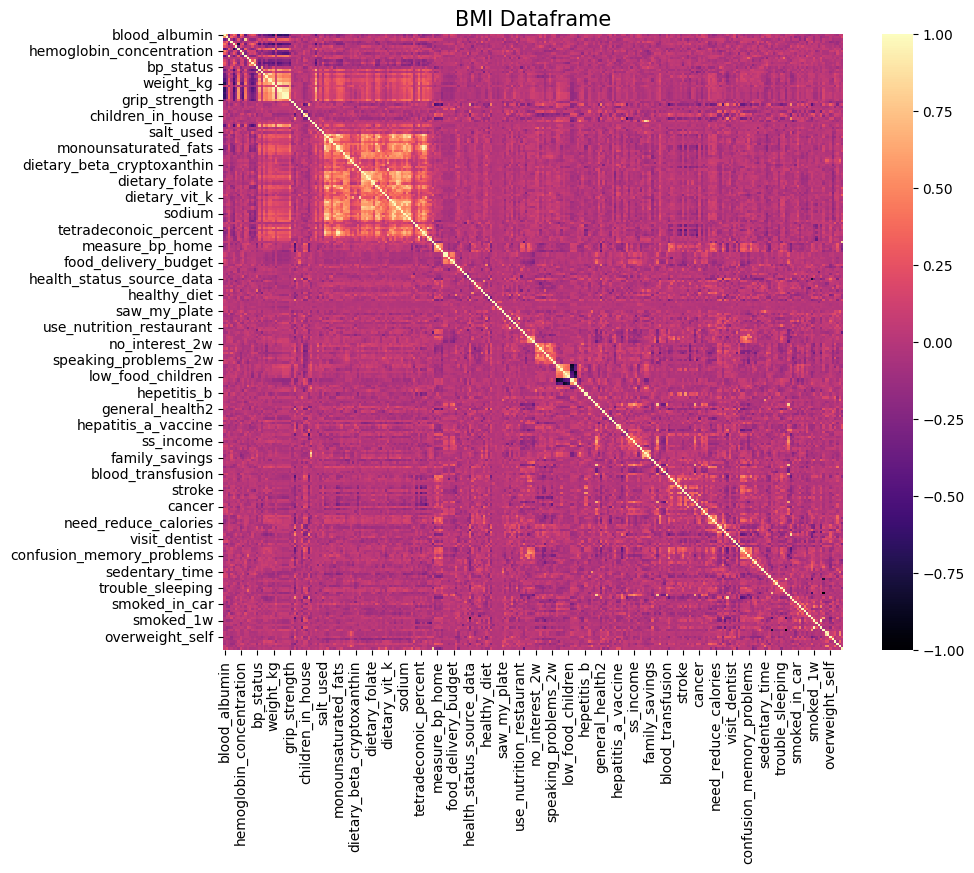

In [298]:
corr_matrix(bmi_df, 'BMI Dataframe')

**Dimensionality Reduction by PCA Discovery**

*Why?* The cleaned dataset has many columns or dimensions or input features. The rows of data therefore only represent a small and non-representative sample. We want to try to reduce the number of dimensions while keeping as much variation in the original dataset as possible.

In [334]:
def fit_and_scale(df):
    ss = StandardScaler()
    X = ss.fit_transform(df)
    return pd.DataFrame(data=X, columns=df.columns[0:])

def expl_var_bargraph(dfx, n, title):
    sns.set(style='whitegrid')
    cmap = sns.color_palette("magma", as_cmap=True)
    pca = PCA(n_components=n)
    dfx_pca = pca.fit(dfx)

    length = len(dfx_pca.explained_variance_ratio_)

    x_vals = [i for i in range(length)]
    y_vals = pca.explained_variance_ratio_
    x_ticks = [i for i in range(0, 100, 20)]


    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_vals,y=y_vals)
    plt.title("{}:Variance of Components".format(title), fontsize=25)
    plt.xlabel("Principal components",fontsize=15)
    plt.ylabel("Explained variance ratio",fontsize=15)
    plt.xticks(x_ticks,fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

def pca_scatter(dfx, n, c):
    pca = PCA(n_components=n)
    dfx_trans = pca.fit_transform(dfx)
    dfx_trans = pd.DataFrame(data=dfx_trans)
    dfx_trans.head(10)

    plt.figure(figsize=(10,6))
    plt.scatter(dfx_trans[0], dfx_trans[1], c=c,edgecolors='k',alpha=0.75,s=150)
    plt.xlabel("Principal component-1",fontsize=15)
    plt.ylabel("Principal component-2",fontsize=15)
    plt.show()

In [335]:
glyc_dfx = fit_and_scale(glyco_df)
glyc_dfx

,blood_albumin,blood_calcium,serum_glucose_mg,blood_protein,lymphocite_percent,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,HDL_mg,inorganic_mercury,...,tobaco_1w,question_mode2,height_in,current_weight_lb,overweight_self,weightloss_desire,weight_1y,weightloss_attempt,greatest_weight,age_when_heaviest
0,-4.086746,-0.999527,-1.189816,-2.983910,1.393443,-1.660190,-1.446947,-2.391609,1.594282,0.713439,...,0.725196,0.656749,-0.211273,-0.027276,-1.161294,-0.500737,-0.224409,-3.626949,-0.139706,-0.142978
1,-1.660050,-2.088072,-1.171422,-0.585151,-0.232242,-0.583995,-0.473716,1.455824,-1.024617,0.713439,...,0.725196,0.656749,-0.205576,-0.333544,-1.161294,-0.500737,-0.249022,0.910681,-0.237164,-0.149346
2,1.171096,-1.362375,-1.153029,-0.884996,2.838497,-1.198964,-2.685604,0.452146,2.145629,0.713439,...,0.725196,0.656749,-0.211273,-0.265484,2.737581,-0.500737,-0.273635,0.910681,-0.265009,-0.144937
3,3.193343,0.814715,-1.088652,2.413297,0.056769,-0.968351,-0.916093,-0.216973,0.078077,0.713439,...,0.725196,0.656749,-0.205576,-0.333544,-1.161294,-0.500737,-0.249022,0.910681,-0.237164,-0.149346
4,-0.042252,-1.120476,-1.085586,-0.085410,-0.262347,2.465221,-1.063553,-0.607292,-1.208400,0.713439,...,-0.845661,0.656749,-0.202727,-0.281365,0.138331,-0.500737,-0.244099,0.910681,-0.231595,-0.145590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.446702,0.451866,2.240556,2.413297,0.183211,-1.045222,-0.385240,0.619426,1.318608,0.713439,...,0.725196,0.656749,-0.205576,-0.265484,2.737581,-0.500737,-0.278557,0.910681,-0.259440,-0.140039
96,-3.682297,-2.692819,2.219097,-2.084375,-1.291948,0.774059,0.823925,-0.440012,2.099683,0.713439,...,0.725196,-1.559846,-0.200828,-0.344887,0.138331,-0.500737,-0.269532,-0.601862,-0.251087,-0.152775
97,-3.682297,1.177563,1.679557,-1.784530,0.327716,1.030296,-0.650667,0.619426,-1.024617,0.713439,...,-3.987373,0.656749,-0.191332,0.136067,-1.161294,-0.500737,-0.071809,0.910681,0.077486,-0.154244
98,1.171096,-0.273830,-1.051865,0.014538,-0.972832,-1.045222,1.561221,-0.384253,0.078077,0.713439,...,0.725196,0.656749,-0.216970,-0.483275,-1.161294,-0.500737,-0.396699,-3.626949,-0.251087,-0.139059


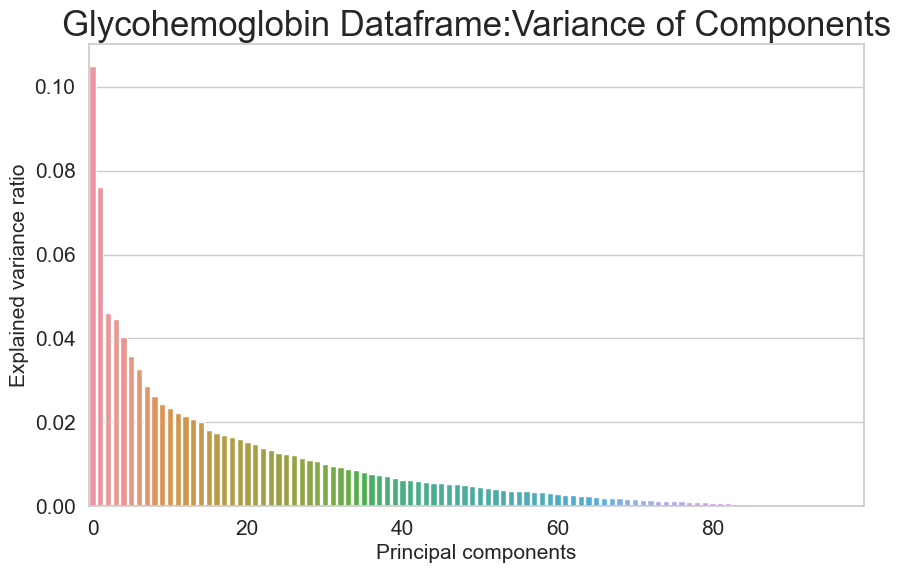

In [336]:
expl_var_bargraph(glyc_dfx, None, 'Glycohemoglobin Dataframe')

2 components can explain over 80% of the variance of our data.

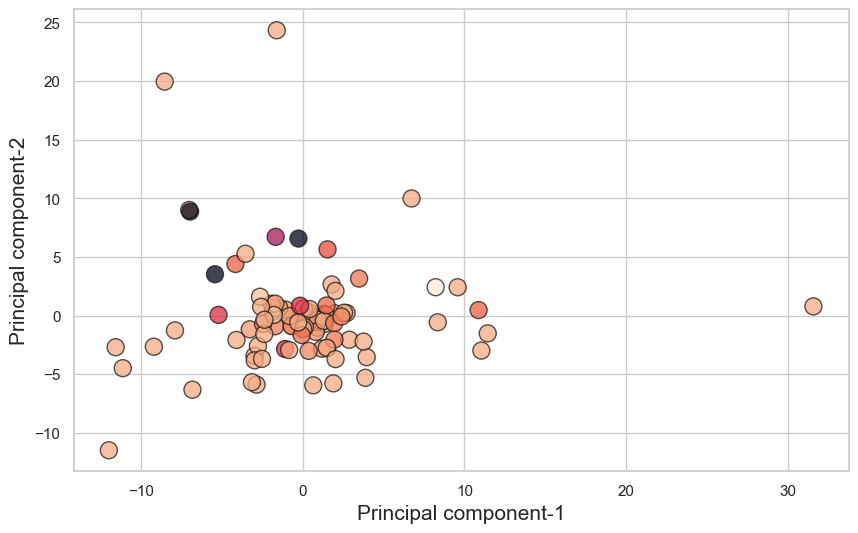

In [344]:
pca_scatter(glyc_dfx, 2, glyc_dfx.diabetes)